# Explaining `BERT` Models with Integrated Gradients

Return to the [castle](https://github.com/Nkluge-correa/teeny-tiny_castle).

**According to "The mythos of model interpretability," these are the properties of an "interpretable model":**

>**A human can repeat ("simulatability") the computation process with a full understanding of the algorithm ("algorithmic transparency"), and every individual part of the model owns an intuitive explanation ("decomposability").**

**Explainable AI (XAI) is an approach to artificial intelligence that aims to achieve this level of interpretability. In it, we seek to create transparent, interpretable models that can provide human-understandable explanations for their decisions or predictions.**

**The goal of XAI is to improve the trustworthiness and reliability of AI systems and facilitate collaboration between humans and machines. One could even say that XAI seeks to help us create a verifiable science of AI. XAI techniques include methods for visualizing model internals, feature importance analysis, and rule extraction, among other methods.**

<img src="https://production-media.paperswithcode.com/methods/new_BERT_Overall.jpg" alt="bert-model" width="800"/>

**Source: _[BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805v2)._**

**`BERT`, short for Bidirectional Encoder Representations from Transformers, is a pre-trained neural network model developed by Google. `BERT` is based on the Transformer architecture and is trained on massive amounts of text data, allowing it to learn the nuances of natural language processing tasks such as text classification, question-answering, and language translation. `BERT` models have become a foundation for many natural language processing applications in the real world due to their high accuracy and versatility.**

**Fine-tuning a `BERT` model involves taking the pre-trained model and training it further on a specific task, such as text classification. During fine-tuning, the weights of the pre-trained `BERT` model are updated based on the specific task at hand. Fine-tuning allows `BERT` to be customized for a specific use case, making it more accurate and efficient for that particular task. One example we have of a fined tuned `BERT` is one of our `Aira` models.**

**[`Aira`](https://playground.airespucrs.org/aira) is a `chatbot` designed to simulate the way a human (expert) would behave during a round of questions and answers (Q&A). `Aira` has many iterations, from a closed-domain chatbot based on pre-defined rules to an open-domain chatbot achieved via fine-tuning pre-trained large language models.**

**In this tutorial, we will be exploring the BERT version of one of our clased domain chatbots (`Aira_BERT`). If you would like to see how our models were trained, visit [this repository](https://github.com/Nkluge-correa/Aira-EXPERT).**

**In this tutorial, we will try to get an understanding of the outputs of this model using a technique called [`Integrated Gradients`](https://github.com/Nkluge-correa/teeny-tiny_castle/blob/45c7ab4bb13a2bed565d4699cc0c62b6c81248d5/ML%20Explainability/NLP%20Interpreter/integrated_gradients_in%20_keras_nlp.ipynb). `Integrated Gradients` is a method to make a classification model interpretable, proposed in Sundararajan et al., "_[Axiomatic Attribution for Deep Networks](https://arxiv.org/abs/1703.01365)_". This methodology uses the gradient to determine what _influence_ the individual parts of an input (_like words in a sentese, or pixels in an image_) have on the output of a model.**

**You can download the English version of [Aira-BERT here](https://drive.google.com/uc?export=download&id=1klgSn9MscPQyy3sAK99IYyr-Liv2fLva).**

In [1]:
from transformers import BertTokenizerFast, TFBertForSequenceClassification


tokenizer = BertTokenizerFast.from_pretrained(f"aira_BERT_en")
model = TFBertForSequenceClassification.from_pretrained(f"aira_BERT_en", 
                                                        id2label=dict([(i, i) for i in range(142)])) 

model.summary()

Some layers from the model checkpoint at aira_BERT_en were not used when initializing TFBertForSequenceClassification: ['dropout_75']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at aira_BERT_en.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  109198    
                                                                 
Total params: 108,419,470
Trainable params: 108,419,470
Non-trainable params: 0
_________________________________________________________________


**The closed domain versions of `Aira` act as a text classification model. Let us then classify some questions into their corresponding label, which are pre-defined answers (you can access the `answers.txt` file in [this repository](https://github.com/Nkluge-correa/Aira-EXPERT/tree/master/data/original_data).)**

In [2]:
from transformers import TextClassificationPipeline
from IPython.display import HTML

with open(f'answers_en.txt', encoding='utf-8') as fp:
    answers = [line.strip() for line in fp]
    fp.close()

# Text has to be lowered and stripped of punctuation
questions = ["what is the purpose of ai robotics ethics society at pucrs",
        "what is your name",
        "what is the weather like today",]

pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer)

predictions = pipe(questions)

for i, prediction in enumerate(predictions):
    display(HTML(f"<b>{i+1} Question</b>: <i>{questions[i]}?</i>"))
    display(HTML(f"<b>Matching Answer for label {prediction['label']}</b>: <i>{answers[int(prediction['label'])]}</i>"))

**The `integrated gradients` method computes the attribution of each feature of a deep learning model based on the gradient of the model's output (prediction) concerning the input. This method applies to any deep learning model for classification and regression tasks.**

**In a text classification model, like here, we will utilize it to interpret its prediction. With integrated gradients, in the end, we will get the attribution score of each input word for the final prediction. We can use this attribution score to determine which words play an important role in our model's final prediction.**

**Below, we implement a simple function that, given a piece of text, a model, and a tokenizer, outputs a list of gradient attributions, the attributed tokens, and the final output class.**

In [3]:
import tensorflow as tf
import numpy as np

def get_gradients(text, model, tokenizer):
    """
    Compute the gradients of a given text with respect to the model's parameters.

    Args:
        text (str): The input text for which gradients need to be computed.
        model: the model that generates the predictions.
        tokenizer: The tokenizer object used for tokenizing the text.

    Returns:
        gradients (list): A list of gradient tensors, each corresponding to a 
        parameter in the model.
        token_words (list): A list of tokens corresponding to the input text.
        prediction_label (str): The predicted label for the input text.
    """
    # get embedding matrix, token ids, and the vocab size
    embedding_matrix = model.bert.embeddings.weights[0]
    vocab_size = embedding_matrix.shape[0]
    encoded_tokens = tokenizer(text, return_tensors="tf")
    token_ids = list(encoded_tokens["input_ids"].numpy()[0])

    # convert token ids to one hot. 
    token_ids_tensor = tf.constant([token_ids], dtype='int32')
    token_ids_tensor_one_hot = tf.one_hot(token_ids_tensor, vocab_size)

    # compute gradients in respect to input embeddings
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        # input variable
        tape.watch(token_ids_tensor_one_hot)

        # forward pass through the models embedding layer
        inputs_embeds = tf.matmul(token_ids_tensor_one_hot,embedding_matrix)

        # forward pass through the rest of the model and get logits
        logits = model({"inputs_embeds": inputs_embeds, "attention_mask": encoded_tokens["attention_mask"] } ).logits

        # get the most likely class
        prediction_class = tf.argmax(logits, axis=1).numpy()[0]

        # get the logit of the most likely class
        target_logit = logits[0][prediction_class]

        #  get gradient of the input with respect to prediction class
        gradient_non_normalized = tf.norm(
            tape.gradient(target_logit, token_ids_tensor_one_hot),axis=2)
        
        # normalize the gradients
        gradient_tensor = (
                gradient_non_normalized /
                tf.reduce_max(gradient_non_normalized)
            )[0].numpy().tolist()
        
        # get translated tokens
        token_words = tokenizer.convert_ids_to_tokens(token_ids)

        return gradient_tensor, token_words, prediction_class

gradient_tensor, token_words, prediction_class = get_gradients(questions[0], model, tokenizer)

display(HTML(f"<b>Text</b>: <i>{questions[0]}?</i>"))
display(HTML(f"<b>Prediction class</b>: <i>{answers[prediction_class]}</i>"))
display(HTML(f"<b>Gradient scores</b>: <br>{dict(zip(token_words, gradient_tensor))}"))


**Let us know to generate a more visual explanation,i.e., a graph that visualizes the gradient scores for each word in the input text. We can also use the gradient scores not just as a quantity, but as a color range, giving us another visualization tool.**

> **Note: In a text classification context, the `[CLS]` and the `[SEP]` tokens can be understood as the `start_of_the_sequence` and `end_of_the_sequence` tokens. In sequence-to-sequence modeling, `[SEP]` is the `seuqnece_separator` token.**

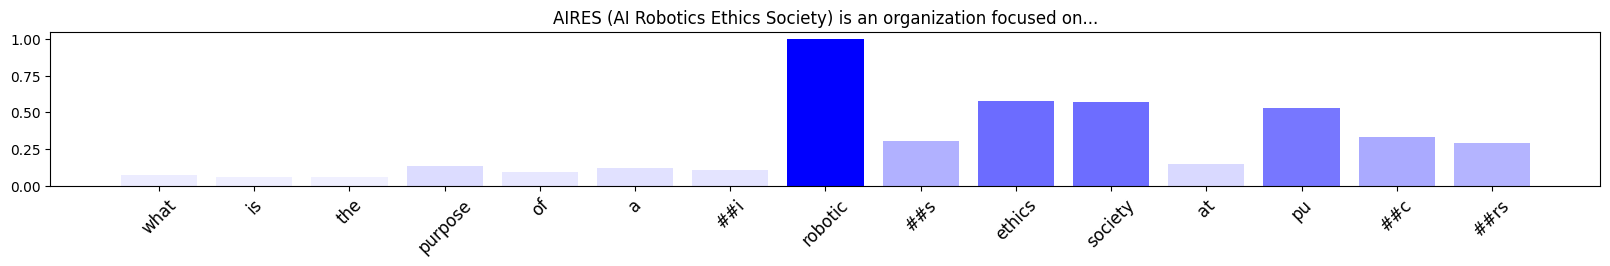

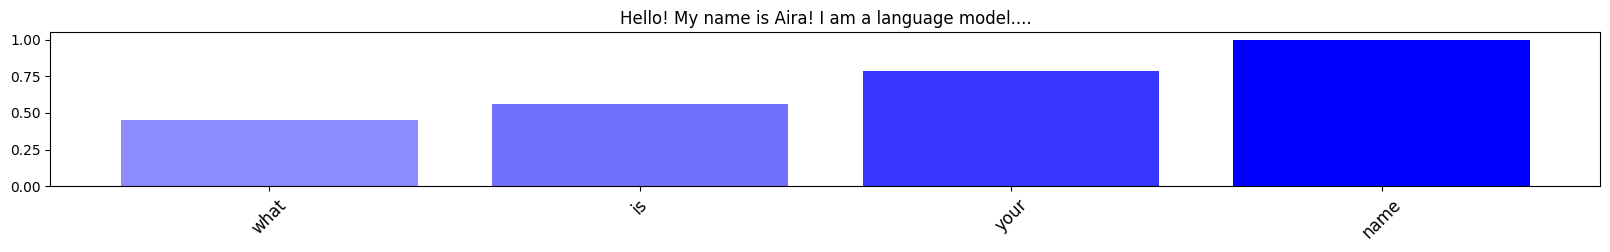

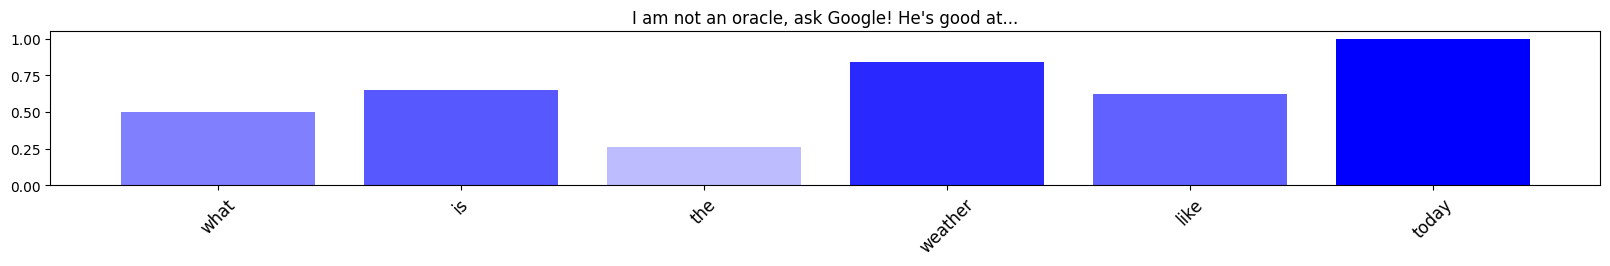

In [4]:
import time
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from IPython.display import HTML

def plot_gradient_scores(question, words, gradients, prediction_class):
    """
    Plot the gradient scores for each word in the input text.

    Args:
        question (str): The input text for which gradients need to be computed.
        words (list): A list of tokens corresponding to the input text.
        gradients (list): A list of gradient tensors, each corresponding to a 
            parameter in the model.
        prediction_label (str): The predicted label for the input text.
    
    Returns:
        None
    """

    # remove special tokens
    words = words[1:-1]
    gradients = gradients[1:-1]

    # get min and max gradients
    minima = min(gradients)
    maxima = max(gradients)

    # normalize gradients to between 0 and 1
    norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.YlOrRd)

    # get colors corresponding to gradients
    colors = [mcolors.to_hex(mapper.to_rgba(v)) for v in gradients]

    # create html string with the words colored corresponding to their gradients
    text_with_gradients = ' '.join([f'''<span style="color:{colors[i]}"><b>{words[i]}</b></span>''' for i in range(len(words))])
    display(HTML(f"<b>Text</b>: <i>{question}?</i>"))
    display(HTML(f"<b>Attention Scores:</b> {text_with_gradients}"))

    # plot the gradients on a bar chart
    plt.figure(figsize=(20,2))
    xvals = [ x + str(i) for i,x in enumerate(words)]
    colors =  [ (0,0,1, c) for c in (gradients) ]
    plt.tick_params(axis='both', which='minor', labelsize=29)
    plt.title(" ".join(answers[prediction_class].split()[:10]) + "...")
    plt.bar(xvals, gradients, color=colors, linewidth=1 )
    plt.xticks(ticks=[i for i in range(len(words))], labels=words, fontsize=12,rotation=45)
    plt.show()

questions = ["what is the purpose of ai robotics ethics society at pucrs",
              "what is your name",
              "what is the weather like today"]

for question in questions:
    gradient_tensor, token_words, prediction_class = get_gradients(question, model, tokenizer)
    plot_gradient_scores(question, token_words, gradient_tensor, prediction_class)

**Presenting simple interpretability tools like this is not hard. Here is a demo app to demonstrate our model prediction with integrated gradients. We are using  [Gradio](https://gradio.app/) to construct the interface.**

> **Gradio is a Python library that enables you to create simple interactive Machine Learning Apps.**

**For more information on how to build apps with Gradio, check our [other tutorials](https://github.com/Nkluge-correa/teeny-tiny_castle/blob/45c7ab4bb13a2bed565d4699cc0c62b6c81248d5/ML%20Intro%20Course/19_quick_AI_app.ipynb), or their [official documentation](https://gradio.app/quickstart/).**

In [7]:
import gradio as gr
import unidecode
import string


# Define the Gradio back-end function
def interpet_BERT_aira(question):

    # preprocess the question (AIRA BERT is trained on lower case text without punctuation)
    question_preprocess = question.translate(str.maketrans('', '', string.punctuation))
    question_preprocess = question_preprocess.lower()
    question_preprocess = unidecode.unidecode(question_preprocess)

    gradient_tensor, token_words, prediction_class = get_gradients(question_preprocess, model, tokenizer)

    # remove special tokens
    token_words = token_words[1:-1]
    gradient_tensor = gradient_tensor[1:-1]

    # normalize gradients to between 0 and 1
    total = sum(gradient_tensor)
    normalized_gradient_tensor = [x/total for x in gradient_tensor]

    # create html resposne string
    output = f"<b>Predicted Answer:</b><br> <i>{answers[prediction_class]}</i><br><br><b>Gradient Scores:</b>"
    
    # output the gradient scores for each word in the input text
    return output, {token_words[i]: normalized_gradient_tensor[i] for i in range(len(normalized_gradient_tensor))}


title = "Explaining BERT Models with Integrated Gradients 🏰"

description = (
  "<center>"
  "<img src='https://production-media.paperswithcode.com/methods/new_BERT_Overall.jpg' width=400>"
  "Aira is a chatbot designed to simulate the way a human (expert) would behave during a round of questions and answers (Q&A). Aira has many iterations, from a closed-domain chatbot based on pre-defined rules to an open-domain chatbot achieved via fine-tuning pre-trained large language models."
  "<br><br>This app was built to provide some insight into how BERT Aira works. Enter a question and see the gradient scores for each word in the input text.<br><br>"
  "</center>"
)

article = (
"<center>"
"Return to the <a href='https://github.com/Nkluge-correa/teeny-tiny_castle'>castle</a>."
"</center>" 
)

# Create the Gradio interface
interface = gr.Interface(
    fn=interpet_BERT_aira,
    inputs=gr.Textbox(placeholder="Enter text here..."),
    outputs=["html", gr.Label(num_top_classes=10)],
    allow_flagging="never",
    title=title, 
    description=description, 
    article=article,
)

# Launch the Gradio interface
interface.launch()


Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


**By applying `Integrated Gradients`, we can gain valuable insights into the inner workings of machine learning models and improve trust, interpretability, and understanding in AI systems, promoting accountability and ethical considerations in these applications.**

---

Return to the [castle](https://github.com/Nkluge-correa/teeny-tiny_castle).